In [14]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
from utils import *

In [16]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

In [17]:
current_time = get_BJ_time()
print(current_time)

0822_18-31-56


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [18]:
df_2019 = pd.read_csv('../input/aptos-data-split/df_2019_sigmaX10.csv')

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [19]:
bs = 32 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

In [20]:
data = (ImageList.from_df(df=df_2019,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
data

ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: None

# Training (Transfer learning)

The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [21]:
def qk(y_pred, y):
    k = torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
    k[k != k] = 0
    k[torch.isinf(k)] = 0
    
    return k

In [22]:
model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

Loaded pretrained weights for efficientnet-b4


In [23]:
learn = Learner(data, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, patience=6)],
                model_dir = '../output/models/')

In [24]:
model_save_name = "efficientnet-b4_0820_01-09-57_stage2_f2"

In [25]:
learn.load(model_save_name)
print()

In [26]:
learn.export("../output/inference/efficientnet-b4_0820_01-09-57_stage2_f1.pkl")

# Optimize the Metric
Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [13]:
import scipy as sp

In [14]:
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

# Submission

In [15]:
learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

In [16]:
optR = OptimizedRounder()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96320e23c8>]], dtype=object)

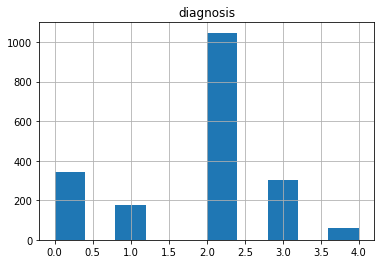

In [18]:
old = pd.read_csv("efficientnet-b4_0820_01-09-57_stage2_f4_submition.csv")
old.hist()

corr: 0.993962386679519



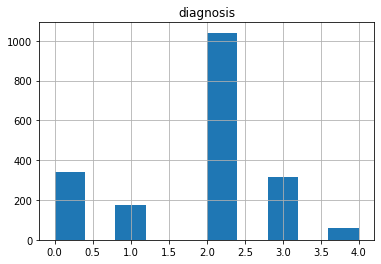

In [29]:
b = 0.95
print("beta={}".format(b))
preds,y = learn.TTA(ds_type=DatasetType.Test, beta=b)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)
test_df.hist()
corr = old.diagnosis.corr(test_df.diagnosis)
print("corr:", corr)
print()

In [24]:
save_filename = '{}_TTA_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

efficientnet-b4_0820_01-09-57_stage2_f4_TTA_submition.csv done


In [22]:
old.diagnosis.value_counts()

2    1047
0     341
3     303
1     176
4      61
Name: diagnosis, dtype: int64

In [23]:
test_df.diagnosis.value_counts()

2    1043
0     336
3     316
1     177
4      56
Name: diagnosis, dtype: int64

In [30]:
test_df.diagnosis.value_counts()

2    1041
0     339
3     314
1     177
4      57
Name: diagnosis, dtype: int64

In [28]:
test_df.diagnosis.value_counts()

2    1023
3     338
0     333
1     177
4      57
Name: diagnosis, dtype: int64